# Least-Squares Background Fitting
We attempt to fit a range of polynomial functions to the background using a linear least-squares fitting routine as implemented by SciPy. This is a binned fitting routine. Optimised parameters are retained in this notebook and in the more general data directory.

In [1]:
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])

## Fetch Mass Distribution
We need to construct an actual background mass distribution to fit from. We will use the background data as given in the real tuple and restrict the sidebands to the values the neural network is currently using. We will also want to try the optimisation using a variety of bin widths.

In [6]:
rf = pd.read_csv('../data_files/7.0.2/all.csv', index_col=[0])
len(rf)

36388

In [10]:
np.count_nonzero(rf['Lb_M'] < 4500) + np.count_nonzero(rf['Lb_M'] > 6500)

68

In [11]:
np.count_nonzero(np.logical_and((rf['Lb_M'] > 5200).to_numpy(), (rf['Lb_M'] < 5800)).to_numpy())

16914

In [2]:
df = pd.read_csv('../data_files/9.0.2/all.csv', index_col=[0])
# Note these data have not been normalised like the training, validation and test CSVs
df.head()

,JPs_FD_ORIVX,LStar_ORIVX_CHI2,Lb_ENDVERTEX_CHI2,LN_Lb_IPCHI2_OWNPV,Lb_PT,LN_Lb_MINIPCHI2,LN_Lb_IP01,LN_Lb_IP23,LN_Lb_IP_OWNPV,p_TRACK_VeloCHI2NDOF,...,JPs_IP_TOPPV,LStar_IP_ORIVX,JPs_IP_ORIVX,LN_SUM_CONEISO,LN_SUM_IPCHI2,LN_COS_THETA,LN_COS_LBDIRA,Lb_M,IsSimulated,category
0,0.059571,30.014437,30.014437,2.718209,3796.757263,2.718209,-2.174524,-3.918732,-3.006345,1.422286,...,0.019891,0.125743,0.016101,-0.022724,6.968428,-7.556597,-0.777249,5867.238192,False,0
1,0.587921,17.846939,17.846939,0.106884,2090.529475,0.106884,-1.423149,-1.528698,-3.873604,0.652654,...,0.216800,0.024445,0.047568,NaN,5.748058,-6.025729,-0.777254,4527.061519,False,0
2,0.469141,44.879555,44.879555,2.439526,3273.707845,2.439526,-1.261208,-2.895975,-2.596784,0.797086,...,0.055197,0.223505,0.035031,-0.172583,7.220638,-7.744115,-0.777232,4960.409661,False,0
3,0.117581,12.662556,12.662556,1.893257,9345.420474,1.893257,-0.498776,-2.597337,-3.568976,0.860139,...,0.074495,0.133724,0.000101,NaN,4.876618,-5.760170,-0.777216,6260.091373,False,0
4,0.077827,9.617642,9.617642,2.249849,6430.697401,2.249849,-1.747564,-3.448630,-2.946442,0.615108,...,0.031785,0.028068,0.010427,-2.046797,5.263091,-5.540257,-0.777291,4577.123988,False,0


In [7]:
len(df)

19997

## Bin the Distribution
Now that we have a dataframe with all the background events we care about it is now prudent to fit our background functions to this. Before doing this these data should be put into bins. The value of bins is variable and will affect the final fit. For this reason we choose the finest bin structure possible.

In [18]:
masses = df[df['category'] == 0]
masses = masses['Lb_M'][masses['IsSimulated'] == False].to_numpy()
# Only keep background events

## Visual Analysis
The best way to get a feel for these data is to do an initial visual analysis. We can do this by plotting the mass distribution and seeing what sort of shape it seems to take. We might normally expect a combinatorial background to be exponentially decaying excluding any resonances.

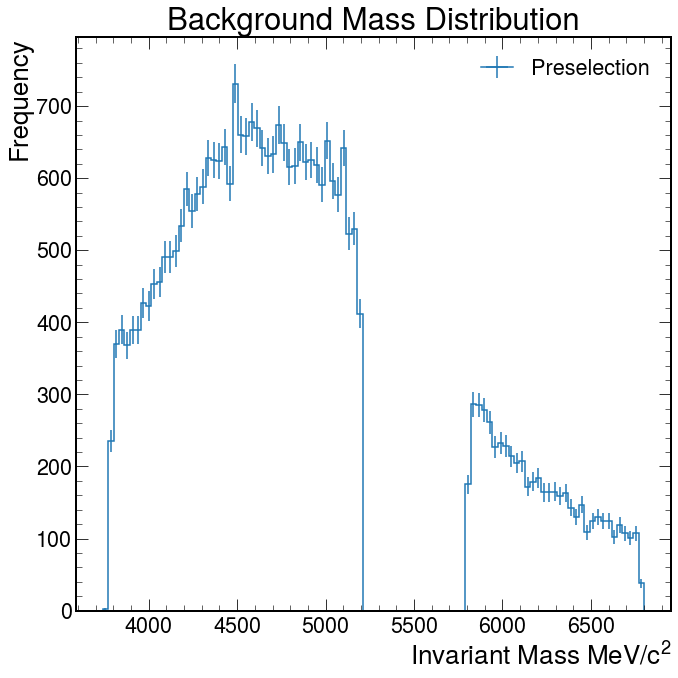

In [19]:
h, bins = np.histogram(masses, bins=100)
fig, ax = plt.subplots(1, 1)
ax.set_title(f"Background Mass Distribution")
hep.histplot(h, bins, yerr=np.sqrt(h), ax=ax, label='Preselection')
#ax.hist(df['Lb_M'], bins=blocks, label='Bayesian Blocks', histtype='step')
plt.ylabel('Frequency', horizontalalignment='right', y=1.0)
plt.xlabel(r'Invariant Mass MeV$/c^2$', horizontalalignment='right', x=1.0)
ax.legend()
plt.tight_layout()
#plt.savefig('../images/BackgroundFits/Mass_Distribution.png', dpi=800)
plt.show()

## Fitting Polynomials

In [20]:
def quadratic(x, N, A, b, c):
    return N*(A*(x**2) + (b*x) + c)

d = np.array([[np.mean(bins[i:i+2]) for i in range(len(bins)-1)], h, np.sqrt(h)]).T
d = d[(d[:,1] >= 10)]

popt, pcov = curve_fit(quadratic, d[:,0], d[:,1], [1e-2, 1e-3, -5, 5e4], d[:,2], absolute_sigma=True)
# Do the optimisation

func_x = np.linspace(low_mass_limit, high_mass_limit, 500)
print(popt)

NameError: name 'low_mass_limit' is not defined

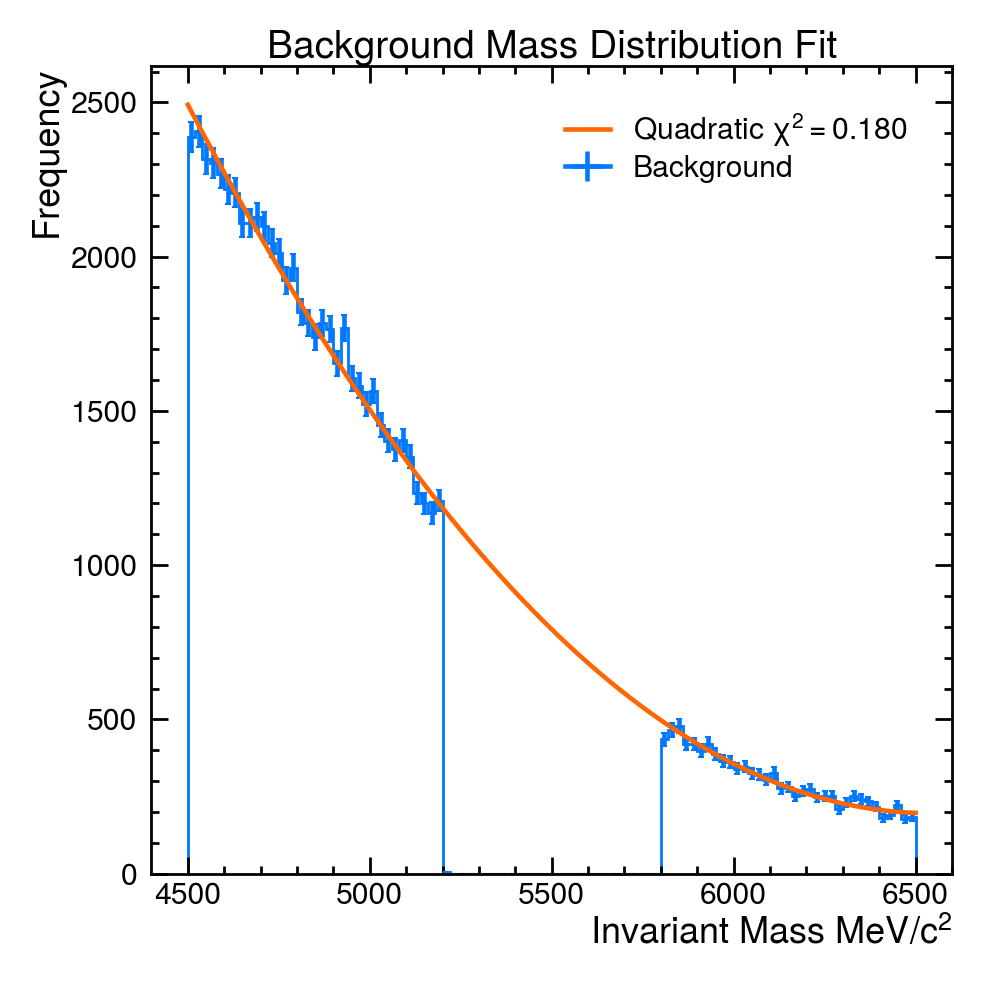

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.set_title(f"Background Mass Distribution Fit")
hep.histplot(h, bins, yerr=np.sqrt(h), ax=ax, label='Background')
ax.plot(func_x, quadratic(func_x, *popt), label=r'Quadratic $\chi^2=0.180$')
plt.ylabel('Frequency', horizontalalignment='right', y=1.0)
plt.xlabel(r'Invariant Mass MeV$/c^2$', horizontalalignment='right', x=1.0)
ax.legend()
plt.tight_layout()
plt.savefig('../images/BackgroundFits/Mass_Distribution_Quadratic_Fit.png', dpi=800)
plt.show()

# Goodness of Fit Tests

In [ ]:
from scipy.stats import chi2
from scipy.stats import ks_2samp

In [ ]:
pred = quadratic(d[:,0], *popt)
chi = np.sum(((d[:,1] - pred)/d[:,2]**2)**2)
chi

0.18023421510866328

We expect chi2 to be distributed according to a chi-square distribution with $\nu=N-p$ d.o.f. I.e. see table in Inference notes that says for $\alpha=0.1$ these values of S should only be exceeded with probability 0.1 if the model is indeed correct.

In [ ]:
chi2.ppf(0.05, df=len(pred)-3)

49.16227017917681

In [ ]:
ks, kspvalue = ks_2samp(d[:,1], pred)
ks, kspvalue

(0.05714285714285714, 0.9998859703191283)

Very high p-value and small statistic for the KS tests informs us that we cannot reject the null hypothesis. I.e. the two distributions are identical with a 99.99% confidence.